<a href="https://colab.research.google.com/github/JmB17/Perosnal-Project/blob/main/Cirrhosis_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prediction of Cirrhosis**

Justice Mansfield-Beaulieu

# Project Overview

Using the data collected from the Mayo Clinic trial in 1974 to 1984, we are going to predict the stage the disease is at based the data collected during clinicl trial.

# Data Dictionary

1) ID: unique identifier

2) N_Days: number of days between
registration and the earlier of death, transplantation, or study analysis time in July 1986

3) Status: status of the patient C
(censored), CL (censored due to liver tx), or D (death)

4) Drug: type of drug D-penicillamine or placebo

5) Age: age in [days]

6) Sex: M (male) or F (female)

7) Ascites: presence of ascites N (No) or Y (Yes)

8) Hepatomegaly: presence of hepatomegaly N (No) or Y (Yes)

9) Spiders: presence of spiders N (No) or Y (Yes)

10) Edema: presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)

11) Bilirubin: serum bilirubin in [mg/dl]

12) Cholesterol: serum cholesterol in [mg/dl]

13) Albumin: albumin in [gm/dl]

14) Copper: urine copper in [ug/day]

15) Alk_Phos: alkaline phosphatase in [U/liter]

16) SGOT: SGOT in [U/ml]

17) Triglycerides: triglicerides in [mg/dl]

18) Platelets: platelets per cubic [ml/1000]

19) Prothrombin: prothrombin time in seconds [s]

20) Stage: histologic stage of disease (1, 2, 3, or 4)

# Load and Inspect Data

In [169]:
# Import Libraries

# Pandas
import pandas as pd
# Numpy
import numpy as np
# Seaborn
import seaborn as sns
# MatplotLib
import matplotlib.pyplot as plt
import matplotlib as mpl
import missingno as msno

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

# Modeling
from sklearn.dummy import DummyRegressor #Baseline model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Classification Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, \
RocCurveDisplay

from sklearn import metrics

## Import SMOTE
## Import special pipeline for smote
from imblearn.pipeline import make_pipeline as smote_pipe

## Set global scikit-learn configuration
from sklearn import set_config
## Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

## Display all columns
pd.set_option('display.max_column', None)

In [170]:
# Printing the current version of these packages in Colab
print('- Package Versions:')
print(f'\tMatplotlib = {mpl.__version__}')
print(f'\tPandas = {pd.__version__}')
print(f'\tSeaborn = {sns.__version__}')

- Package Versions:
	Matplotlib = 3.7.1
	Pandas = 1.5.3
	Seaborn = 0.12.2


# Functions

In [171]:
# Function here returns a histogram with mean and medium line calculation and a boxplot of numerical columns
def hist_box_plot(data, x, figsize=(10,5)):
  sns.plotting_context('notebook')
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

  # Plot Histogram
  sns.histplot(data=data, x=x, ax=axes[0])
  axes[0].tick_params(axis='x', rotation = 0)

  # Plot Boxplot
  sns.boxplot(data=data, x=x, ax=axes[1])
  axes[1].tick_params(axis='x', rotation = 0)

  # Calculate mean and median line with labels
  mean1 = data[x].mean()
  axes[0].axvline(mean1, color='k', ls='-', label=f"{x} mean = {round(mean1, 2)}")

  med1 = data[x].median()
  axes[0].axvline(med1, color='k', ls=':', label=f"{x} median = {round(med1, 2)}")

  axes[0].legend() # Add legend to the hisplot

  # Set Title
  fig.suptitle(f"Count of {x}")

  # Fix layout
  fig.tight_layout()


  # Return
  return fig, axes

In [172]:
## Define a function that takes in arguments and prints out a classification report and confusion matrix
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                            cmap='Greens', normalize=None, classes=None,
                            figsize=(20,5), name='Classification Model',
                            average='binary', zero_division=0):
  # Gather model predictions
  train_preds = model.predict(X_train)
  test_preds = model.predict(X_test)

  # Display classification report and confusion matrices
  print('====Train Set Metrics===')
  print(metrics.classification_report(y_train, train_preds,
                                      zero_division=0,
                                      target_names=classes))

  print('===Test Set Metrics===')
  print(metrics.classification_report(y_test, test_preds,
                                      zero_division=0,
                                      target_names=classes))

  fig, axes = plt.subplots(ncols=2, figsize=figsize)

  ConfusionMatrixDisplay.from_predictions(y_train, train_preds, cmap=cmap,
                                display_labels=classes,
                                normalize=normalize, ax=axes[0])
  axes[0].set_title('Train Confusion Matrix')

  ConfusionMatrixDisplay.from_predictions(y_test, test_preds, cmap=cmap,
                              display_labels=classes,
                              normalize=normalize, ax=axes[1])
  axes[1].set_title('Test Confusion Matrix')
  plt.show()

  # If there are more than 2 classes and an average has not been set,
  # set average to 'macro'
  if average == 'binary' and y_train.nunique() > 2:
    average = 'macro'

  # Create a dataframe of scores to return
  scores = pd.DataFrame()

  # Training

  scores.loc[name, 'Train Accuracy'] = accuracy_score(y_train, train_preds)
  scores.loc[name, 'Train Recall'] = recall_score(y_train, train_preds,
                                                           average=average,
                                                       zero_division=zero_division)
  scores.loc[name, 'Train Precision'] = precision_score(y_train, train_preds,
                                                           average=average,
                                                      zero_division=zero_division)
  scores.loc[name, 'Train F1-Score'] = f1_score(y_train, train_preds,
                                                           average=average,
                                                     zero_division=zero_division)

  # Testing
  scores.loc[name, 'Test Accuracy'] = accuracy_score(y_test, test_preds)
  scores.loc[name, 'Test Recall'] = recall_score(y_test, test_preds,
                                                           average=average,
                                                      zero_division=zero_division)
  scores.loc[name, 'Test Precision'] = precision_score(y_test, test_preds,
                                                           average=average,
                                                      zero_division=zero_division)
  scores.loc[name, 'Test F1-Score'] = f1_score(y_test, test_preds,
                                                           average=average,
                                                     zero_division=zero_division)

  return scores


In [173]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [174]:
# Import Cirrhosis Prediction Data

df = pd.read_csv('/content/drive/MyDrive/CodingDojo/02-MachineLearning/Week07/Data/cirrhosis.csv')

# Create copy of original data for Machine learning late
# df_ml = df.copy()

In [175]:
# Display first 5 rows
df.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [176]:
# Use .info() to show rows and columns
df.info()
# 418 rows and 20 columns
# There are 13 Numerical datatypes(3-Int, 10-Floats)
# There are 7 categorical datatypes(7 Strings)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

# Data Cleaning

## Check Data Types

In [177]:
# Display categorical datatypes columns
df.select_dtypes(include='object')

,Status,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema
0,D,D-penicillamine,F,Y,Y,Y,Y
1,C,D-penicillamine,F,N,Y,Y,N
2,D,D-penicillamine,M,N,N,N,S
3,D,D-penicillamine,F,N,Y,Y,S
4,CL,Placebo,F,N,Y,Y,N
...,...,...,...,...,...,...,...
413,D,NaN,F,NaN,NaN,NaN,N
414,C,NaN,F,NaN,NaN,NaN,N
415,C,NaN,F,NaN,NaN,NaN,N
416,C,NaN,F,NaN,NaN,NaN,N


All of these columns are looking okay for now, I see null values but we will handle these later on.

In [178]:
# Display numerical int datatype columns
df.select_dtypes(include='number')

,ID,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,21464,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,20617,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,25594,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,19994,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,13918,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,414,681,24472,1.2,NaN,2.96,NaN,NaN,NaN,NaN,174.0,10.9,3.0
414,415,1103,14245,0.9,NaN,3.83,NaN,NaN,NaN,NaN,180.0,11.2,4.0
415,416,1055,20819,1.6,NaN,3.42,NaN,NaN,NaN,NaN,143.0,9.9,3.0
416,417,691,21185,0.8,NaN,3.75,NaN,NaN,NaN,NaN,269.0,10.4,3.0


All of the numeric column are looking good except the 'ID' column, this column seems useless since we already have a base index when creating the Dataframe. Lets drop this column.

In [179]:
df = df.drop(columns=['ID'])

In [180]:
# Check if column is dropped
df.select_dtypes('object')

# The column is successfully removed

,Status,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema
0,D,D-penicillamine,F,Y,Y,Y,Y
1,C,D-penicillamine,F,N,Y,Y,N
2,D,D-penicillamine,M,N,N,N,S
3,D,D-penicillamine,F,N,Y,Y,S
4,CL,Placebo,F,N,Y,Y,N
...,...,...,...,...,...,...,...
413,D,NaN,F,NaN,NaN,NaN,N
414,C,NaN,F,NaN,NaN,NaN,N
415,C,NaN,F,NaN,NaN,NaN,N
416,C,NaN,F,NaN,NaN,NaN,N


## Checking for Duplicate Rows

In [181]:
# Checking for duplicate data
# Create a filter that identitfies duplicate rows
duplicated_rows = df.duplicated()

# Get sum of sum of duplicated rows filter
duplicated_rows.sum()
# We have 0 duplicate rows which is great

0

## Inspect Values for Errors

### Numerical Columns

In [182]:
df.describe(include='number')

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,418.000000,418.000000,418.000000,284.000000,418.000000,310.000000,312.000000,312.000000,282.000000,407.000000,416.000000,412.000000
mean,1917.782297,18533.351675,3.220813,369.510563,3.497440,97.648387,1982.655769,122.556346,124.702128,257.024570,10.731731,3.024272
std,1104.672992,3815.845055,4.407506,231.944545,0.424972,85.613920,2140.388824,56.699525,65.148639,98.325585,1.022000,0.882042
min,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,1092.750000,15644.500000,0.800000,249.500000,3.242500,41.250000,871.500000,80.600000,84.250000,188.500000,10.000000,2.000000
50%,1730.000000,18628.000000,1.400000,309.500000,3.530000,73.000000,1259.000000,114.700000,108.000000,251.000000,10.600000,3.000000
75%,2613.500000,21272.500000,3.400000,400.000000,3.770000,123.000000,1980.000000,151.900000,151.000000,318.000000,11.100000,4.000000
max,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,721.000000,18.000000,4.000000


All of the numeric values look okay for now,
Since age is measured in days and not years, thats why the values are so high. We are most likely going to convert that to years for easier to read data.

### Categorical Columns

In [183]:
# Show the string columns
string_cols = df.select_dtypes("object").columns
string_cols

Index(['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object')

In [184]:
# Show values counts for all categorical columns
for col in string_cols:
  print(f'Value Counts for {col}')
  print(df[col].value_counts())
  print('\n')

Value Counts for Status
C     232
D     161
CL     25
Name: Status, dtype: int64


Value Counts for Drug
D-penicillamine    158
Placebo            154
Name: Drug, dtype: int64


Value Counts for Sex
F    374
M     44
Name: Sex, dtype: int64


Value Counts for Ascites
N    288
Y     24
Name: Ascites, dtype: int64


Value Counts for Hepatomegaly
Y    160
N    152
Name: Hepatomegaly, dtype: int64


Value Counts for Spiders
N    222
Y     90
Name: Spiders, dtype: int64


Value Counts for Edema
N    354
S     44
Y     20
Name: Edema, dtype: int64




All categorical columns match the data dictionary and doesn't show any inconsistance values.

## Checking for Unique Values

In [185]:
# Check number of unquie values for each column
df.nunique()

N_Days           399
Status             3
Drug               2
Age              344
Sex                2
Ascites            2
Hepatomegaly       2
Spiders            2
Edema              3
Bilirubin         98
Cholesterol      201
Albumin          154
Copper           158
Alk_Phos         295
SGOT             179
Tryglicerides    146
Platelets        243
Prothrombin       48
Stage              4
dtype: int64

In [186]:
# Get % of unquie values for each column
df.nunique() / len(df) * 100

N_Days           95.454545
Status            0.717703
Drug              0.478469
Age              82.296651
Sex               0.478469
Ascites           0.478469
Hepatomegaly      0.478469
Spiders           0.478469
Edema             0.717703
Bilirubin        23.444976
Cholesterol      48.086124
Albumin          36.842105
Copper           37.799043
Alk_Phos         70.574163
SGOT             42.822967
Tryglicerides    34.928230
Platelets        58.133971
Prothrombin      11.483254
Stage             0.956938
dtype: float64

## Identify Missing Values

In [187]:
# Create a filter showing the sum of Null values in all columns
null_sum = df.isna().sum()
# print filter
null_sum

N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

In [188]:
# Find % of null values for each column
null_percent = null_sum/len(df)*100
null_percent

N_Days            0.000000
Status            0.000000
Drug             25.358852
Age               0.000000
Sex               0.000000
Ascites          25.358852
Hepatomegaly     25.358852
Spiders          25.358852
Edema             0.000000
Bilirubin         0.000000
Cholesterol      32.057416
Albumin           0.000000
Copper           25.837321
Alk_Phos         25.358852
SGOT             25.358852
Tryglicerides    32.535885
Platelets         2.631579
Prothrombin       0.478469
Stage             1.435407
dtype: float64

 None of our columns for missing over or close to 50% of the data so it would be best to keep them and handle the missing values.

<Axes: >

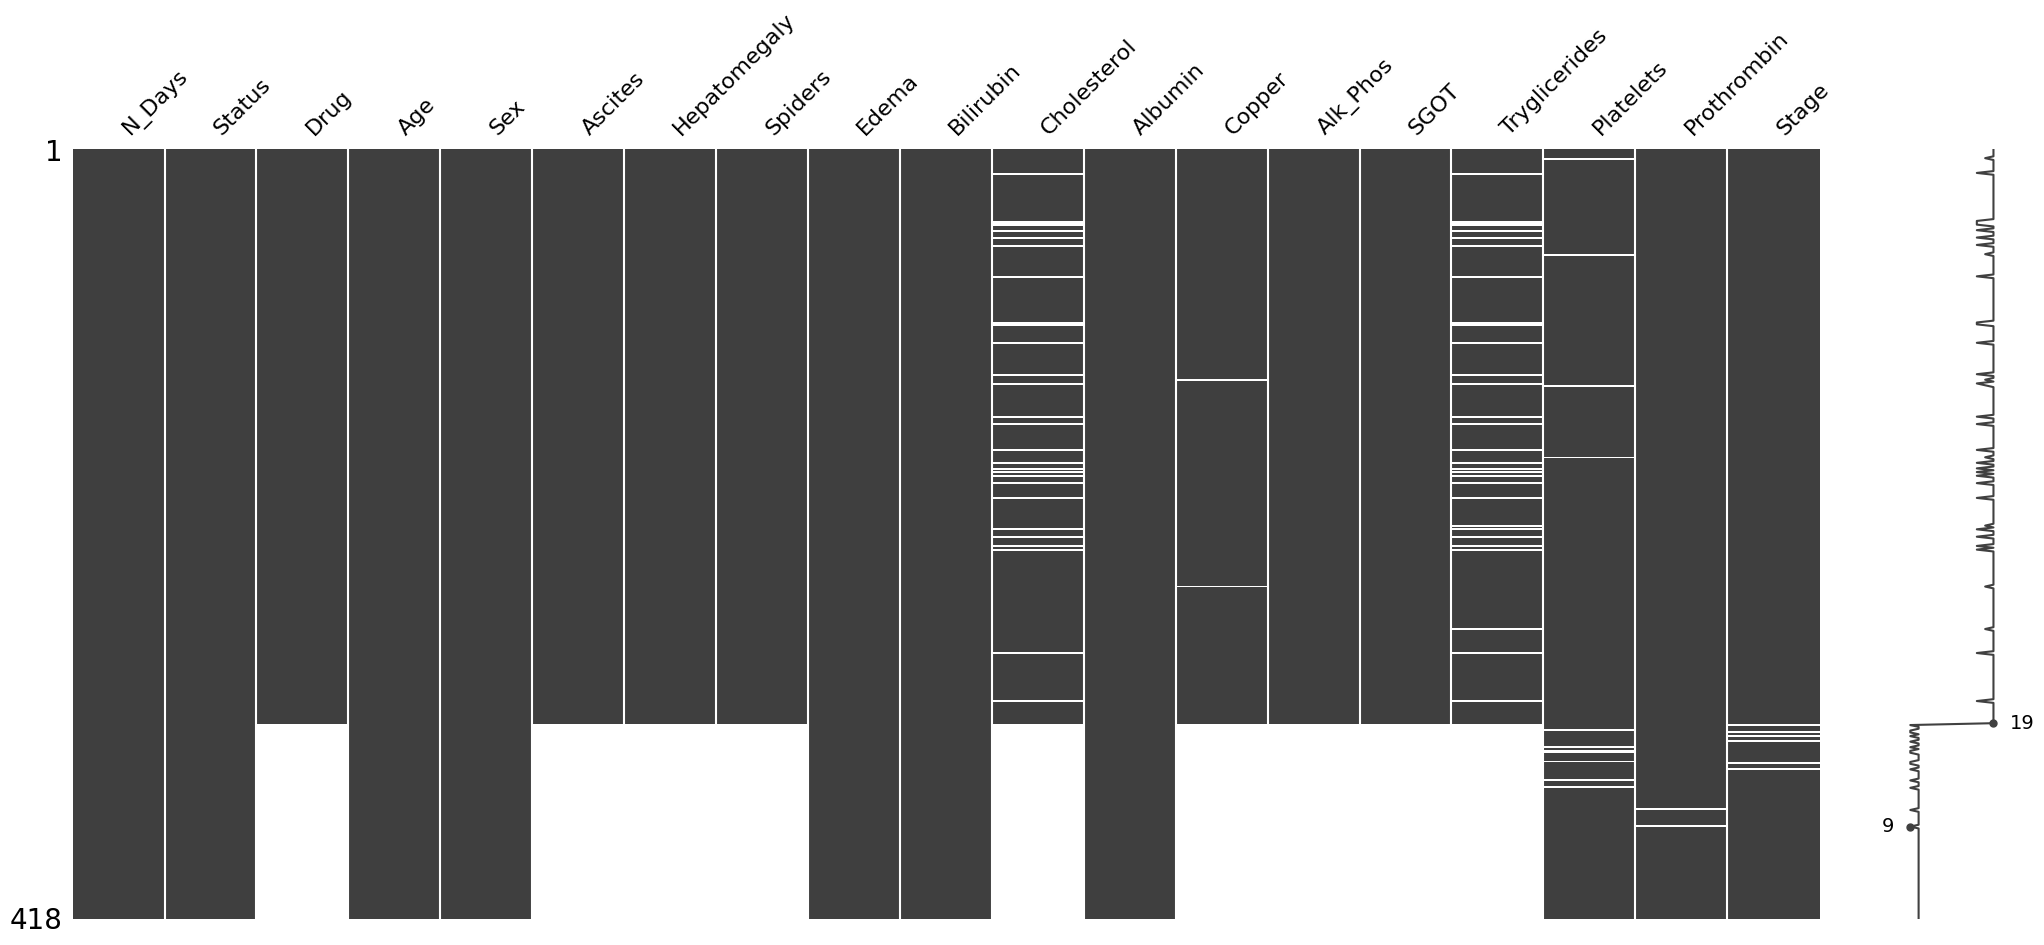

In [189]:
# Visulaize the missing values
msno.matrix(df)

For these categorical columns with missing values I will set them to "unknown" so they aren't creating bias in our data.

### Drug Column

In [190]:
df['Drug'].value_counts(dropna=False)

D-penicillamine    158
Placebo            154
NaN                106
Name: Drug, dtype: int64

In [194]:
# Replacing Null values in Drug column with 'Unknown' value
df['Drug'] = df['Drug'].fillna("Unknown")

# Check values counts to see if the null values are changed
df['Drug'].value_counts(dropna=False)

D-penicillamine    158
Placebo            154
Unknown            106
Name: Drug, dtype: int64

### Ascites Column

In [191]:
df['Ascites'].value_counts(dropna=False)

N      288
NaN    106
Y       24
Name: Ascites, dtype: int64

In [195]:
# Replacing Null values in Ascites column with 'Unknown' value
df['Ascites'] = df['Ascites'].fillna("Unknown")

# Check values counts to see if the null values are changed
df['Ascites'].value_counts(dropna=False)

N          288
Unknown    106
Y           24
Name: Ascites, dtype: int64

### Hepatomegaly Column

In [192]:
df['Hepatomegaly'].value_counts(dropna=False)

Y      160
N      152
NaN    106
Name: Hepatomegaly, dtype: int64

In [196]:
# Replacing Null values in Hepatomegaly column with 'Unknown' value
df['Hepatomegaly'] = df['Hepatomegaly'].fillna("Unknown")

# Check values counts to see if the null values are changed
df['Hepatomegaly'].value_counts(dropna=False)

Y          160
N          152
Unknown    106
Name: Hepatomegaly, dtype: int64

### Spiders Column

In [193]:
df['Spiders'].value_counts(dropna=False)

N      222
NaN    106
Y       90
Name: Spiders, dtype: int64

In [197]:
# Replacing Null values in Spiders column with 'Unknown' value
df['Spiders'] = df['Spiders'].fillna("Unknown")

# Check values counts to see if the null values are changed
df['Spiders'].value_counts(dropna=False)

N          222
Unknown    106
Y           90
Name: Spiders, dtype: int64

Moving on to our numeric missing values, the best strategy for handking these I believe would be to input the mean value for the missing values.

### Cholesterol Column

In [219]:
df['Cholesterol'].value_counts(dropna=False)

369.510563    134
260.000000      4
316.000000      4
448.000000      4
257.000000      3
             ... 
486.000000      1
528.000000      1
458.000000      1
950.000000      1
576.000000      1
Name: Cholesterol, Length: 202, dtype: int64

In [200]:
mean_cholesterol = df['Cholesterol'].mean()
mean_cholesterol

369.51056338028167

In [201]:
df['Cholesterol'].fillna(value = mean_cholesterol, inplace=True)

In [202]:
df['Cholesterol'].value_counts(dropna=False)

369.510563    134
260.000000      4
316.000000      4
448.000000      4
257.000000      3
             ... 
486.000000      1
528.000000      1
458.000000      1
950.000000      1
576.000000      1
Name: Cholesterol, Length: 202, dtype: int64

### Copper Column

In [203]:
df['Copper'].value_counts(dropna=False)

NaN      108
52.0       8
67.0       7
58.0       6
75.0       6
        ... 
178.0      1
110.0      1
154.0      1
269.0      1
186.0      1
Name: Copper, Length: 159, dtype: int64

In [204]:
mean_copper = df['Copper'].mean()
mean_copper

97.64838709677419

In [205]:
df['Copper'].fillna(value = mean_copper, inplace=True)

In [206]:
df['Copper'].value_counts(dropna=False)

97.648387     108
52.000000       8
67.000000       7
58.000000       6
75.000000       6
             ... 
178.000000      1
110.000000      1
154.000000      1
269.000000      1
186.000000      1
Name: Copper, Length: 159, dtype: int64

### Tryglicerides Column

In [207]:
df['Tryglicerides'].value_counts(dropna=False)

NaN      136
118.0      7
90.0       6
91.0       6
108.0      5
        ... 
272.0      1
318.0      1
243.0      1
598.0      1
82.0       1
Name: Tryglicerides, Length: 147, dtype: int64

In [208]:
mean_tryglicerides = df['Tryglicerides'].mean()
mean_tryglicerides

124.70212765957447

In [209]:
df['Tryglicerides'].fillna(value = mean_tryglicerides, inplace=True)

In [210]:
df['Tryglicerides'].value_counts(dropna=False)

124.702128    136
118.000000      7
90.000000       6
91.000000       6
108.000000      5
             ... 
272.000000      1
318.000000      1
243.000000      1
598.000000      1
82.000000       1
Name: Tryglicerides, Length: 147, dtype: int64

### Platelets Column

In [211]:
df['Platelets'].value_counts(dropna=False)

NaN      11
344.0     6
165.0     5
213.0     5
269.0     5
         ..
140.0     1
301.0     1
339.0     1
108.0     1
350.0     1
Name: Platelets, Length: 244, dtype: int64

In [212]:
mean_platelets = df['Platelets'].mean()
mean_platelets

257.02457002457004

In [213]:
df['Platelets'].fillna(value = mean_platelets, inplace=True)

In [214]:
df['Platelets'].value_counts(dropna=False)

257.02457    11
344.00000     6
165.00000     5
213.00000     5
269.00000     5
             ..
140.00000     1
301.00000     1
339.00000     1
108.00000     1
350.00000     1
Name: Platelets, Length: 244, dtype: int64

### Prothrombin Column

In [215]:
df['Prothrombin'].value_counts(dropna=False)

10.6    39
11.0    32
10.0    25
9.9     24
9.8     22
10.1    22
10.3    17
10.8    16
10.9    15
10.2    15
10.4    15
9.6     14
11.2    13
10.5    13
11.5    12
11.1    12
10.7    11
9.7     11
9.5      9
12.0     8
11.6     6
11.7     6
11.4     6
12.1     5
11.3     4
13.0     4
12.4     4
11.8     4
12.3     3
12.2     3
13.2     3
11.9     2
12.7     2
13.6     2
9.0      2
12.9     2
NaN      2
9.4      2
14.1     1
13.3     1
12.6     1
15.2     1
9.1      1
17.1     1
18.0     1
13.8     1
13.1     1
9.3      1
9.2      1
Name: Prothrombin, dtype: int64

In [216]:
mean_prothrombin = df['Prothrombin'].mean().round(2)
mean_prothrombin

10.73

In [217]:
df['Prothrombin'].fillna(value = mean_prothrombin, inplace=True)

In [218]:
df['Prothrombin'].value_counts(dropna=False)

10.60    39
11.00    32
10.00    25
9.90     24
9.80     22
10.10    22
10.30    17
10.80    16
10.90    15
10.20    15
10.40    15
9.60     14
11.20    13
10.50    13
11.50    12
11.10    12
10.70    11
9.70     11
9.50      9
12.00     8
11.60     6
11.70     6
11.40     6
12.10     5
11.30     4
13.00     4
12.40     4
11.80     4
12.30     3
12.20     3
13.20     3
11.90     2
12.70     2
13.60     2
9.00      2
12.90     2
10.73     2
9.40      2
14.10     1
13.30     1
12.60     1
15.20     1
9.10      1
17.10     1
18.00     1
13.80     1
13.10     1
9.30      1
9.20      1
Name: Prothrombin, dtype: int64

In [198]:
df['Stage'].value_counts(dropna=False)

3.0    155
4.0    144
2.0     92
1.0     21
NaN      6
Name: Stage, dtype: int64

# EDA

## Find correlations in our data


In [220]:
df_corr = df.corr()
df_corr

<ipython-input-220-0c96883f2151>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df.corr()


,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
N_Days,1.000000,-0.125934,-0.403953,-0.114683,0.430829,-0.319775,0.149269,-0.225492,-0.126912,0.147495,-0.111037,-0.366193
Age,-0.125934,1.000000,0.002362,-0.130578,-0.182350,0.053617,-0.047247,-0.149869,0.018278,-0.145948,0.113731,0.189083
Bilirubin,-0.403953,0.002362,1.000000,0.337809,-0.314177,0.405228,0.116984,0.441730,0.371490,-0.013347,0.312585,0.200731
Cholesterol,-0.114683,-0.130578,0.337809,1.000000,-0.054572,0.123024,0.140112,0.337282,0.276828,0.150683,-0.025016,0.008999
Albumin,0.430829,-0.182350,-0.314177,-0.054572,1.000000,-0.225532,-0.101456,-0.220047,-0.080804,0.156384,-0.199374,-0.305296
Copper,-0.319775,0.053617,0.405228,0.123024,-0.225532,1.000000,0.187285,0.293547,0.272473,-0.053898,0.185349,0.232264
Alk_Phos,0.149269,-0.047247,0.116984,0.140112,-0.101456,0.187285,1.000000,0.112217,0.168702,0.142731,0.089384,0.041273
SGOT,-0.225492,-0.149869,0.441730,0.337282,-0.220047,0.293547,0.112217,1.000000,0.119463,-0.118988,0.112174,0.164945
Tryglicerides,-0.126912,0.018278,0.371490,0.276828,-0.080804,0.272473,0.168702,0.119463,1.000000,0.080049,0.016290,0.099874
Platelets,0.147495,-0.145948,-0.013347,0.150683,0.156384,-0.053898,0.142731,-0.118988,0.080049,1.000000,-0.153700,-0.248729


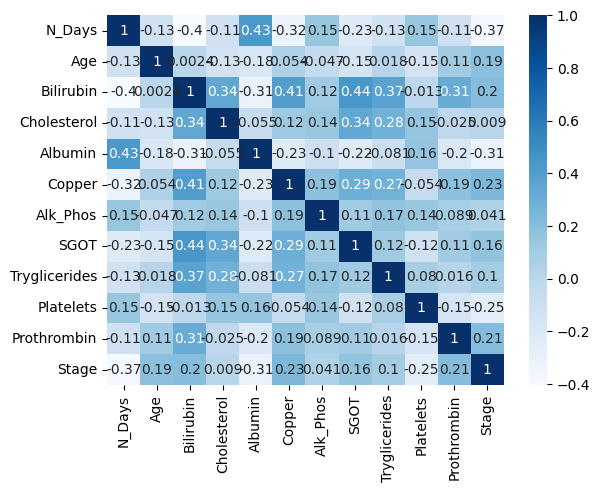

In [224]:
# Create a heatmap to show correlations of numeric data
ax = sns.heatmap(df_corr, cmap='Blues', annot=True)

## Univariate Visuals for target and all features

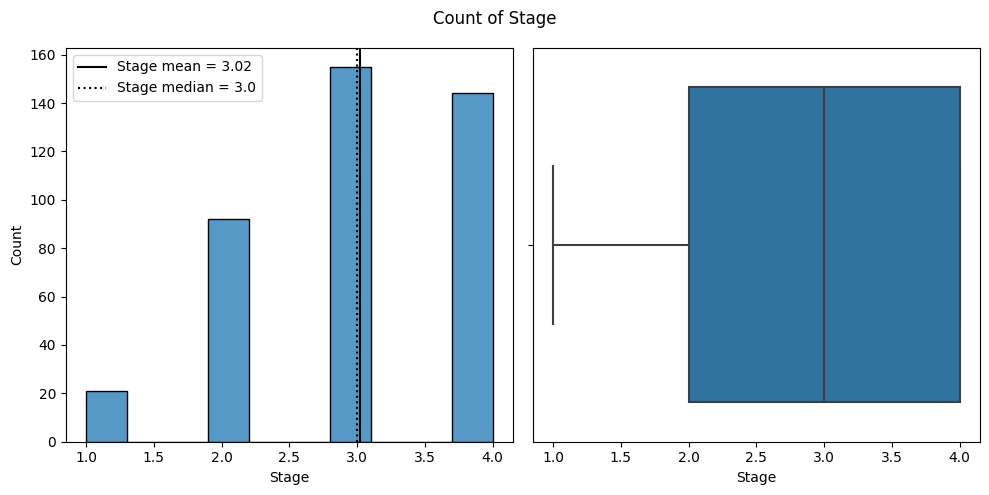

In [225]:
# Target: Stage
fig, axes=hist_box_plot(df,'Stage')


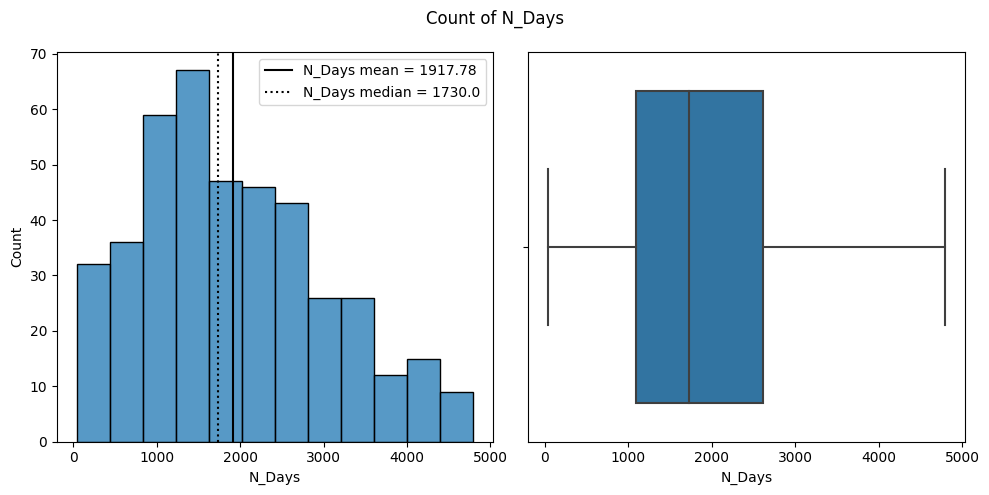

In [227]:
# N_Days
fig, axes=hist_box_plot(df,'N_Days')

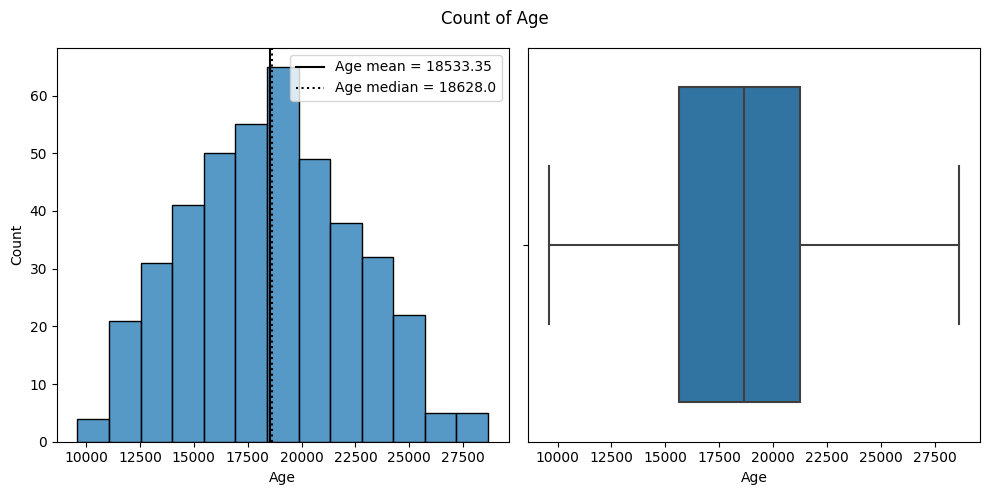

In [228]:
# Age
fig, axes=hist_box_plot(df,'Age')

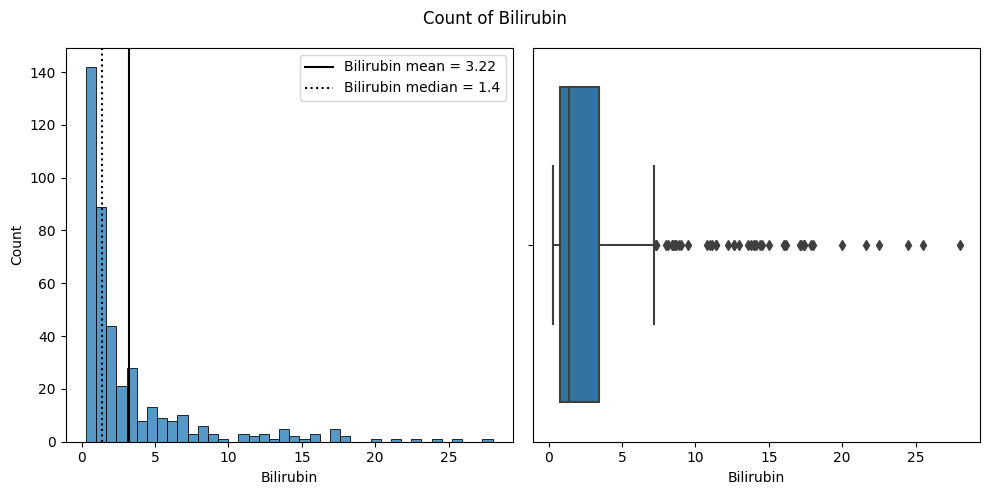

In [230]:
# Bilirubin
fig, axes=hist_box_plot(df,'Bilirubin')

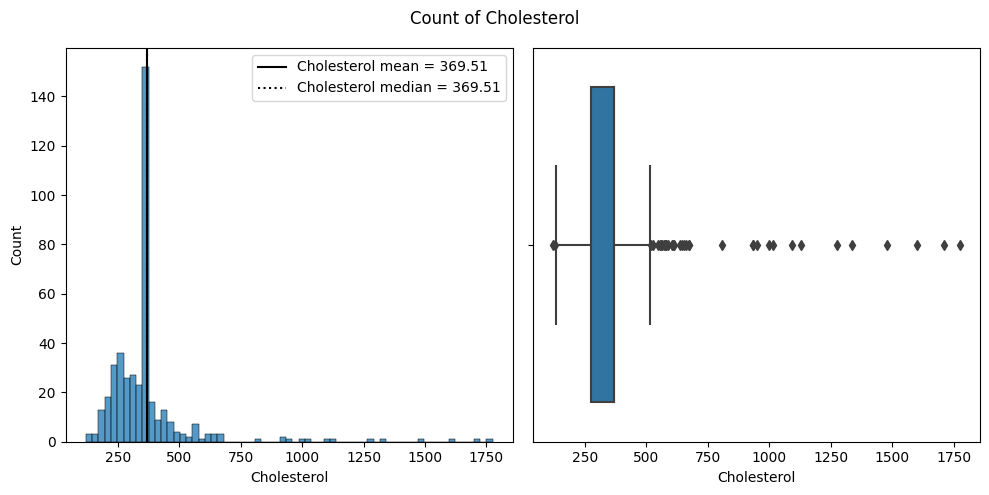

In [232]:
# Cholesterol
fig, axes=hist_box_plot(df,'Cholesterol')

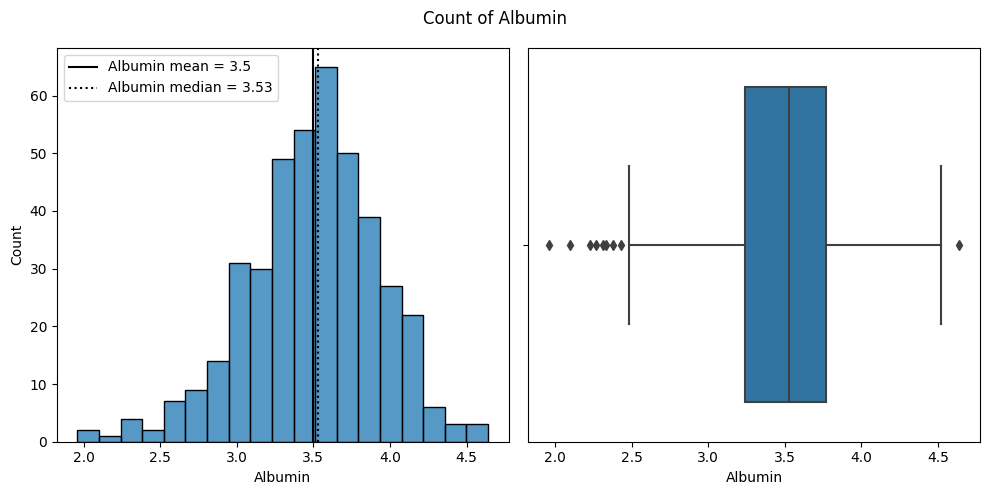

In [233]:
# Albumin
fig, axes=hist_box_plot(df,'Albumin')

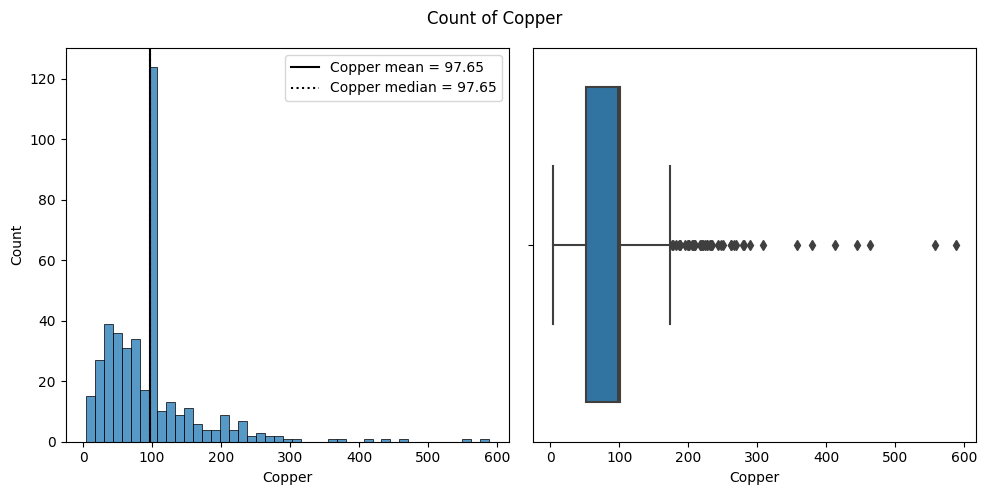

In [234]:
# Copper
fig, axes=hist_box_plot(df,'Copper')

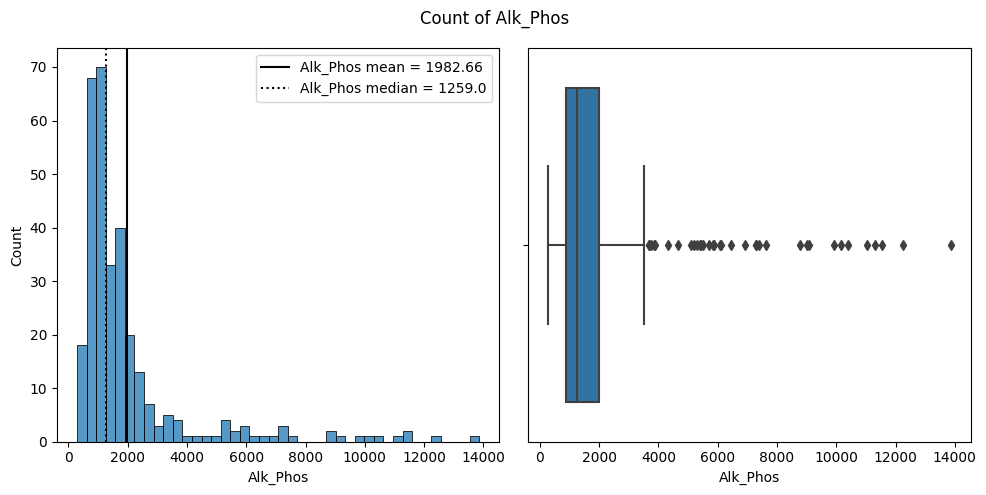

In [236]:
# Alk_Phos
fig, axes=hist_box_plot(df,'Alk_Phos')

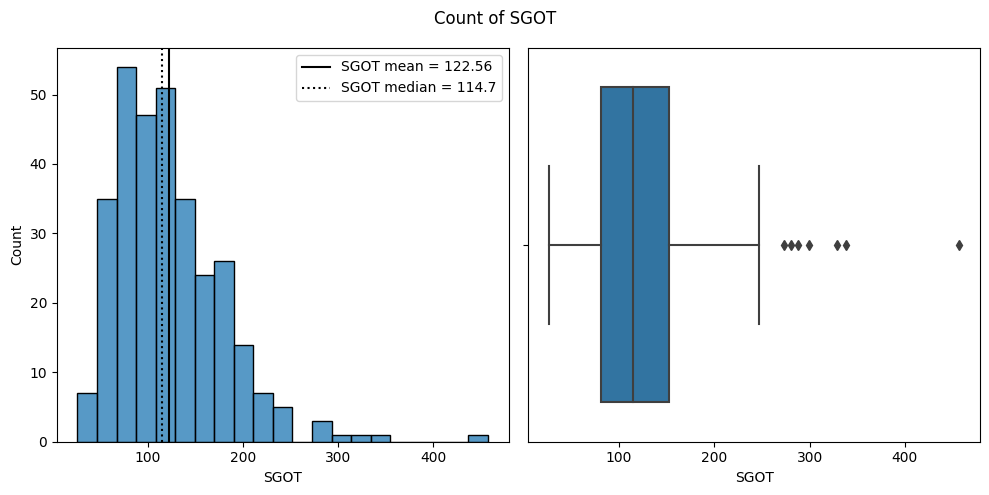

In [238]:
# SGOT
fig, axes=hist_box_plot(df,'SGOT')

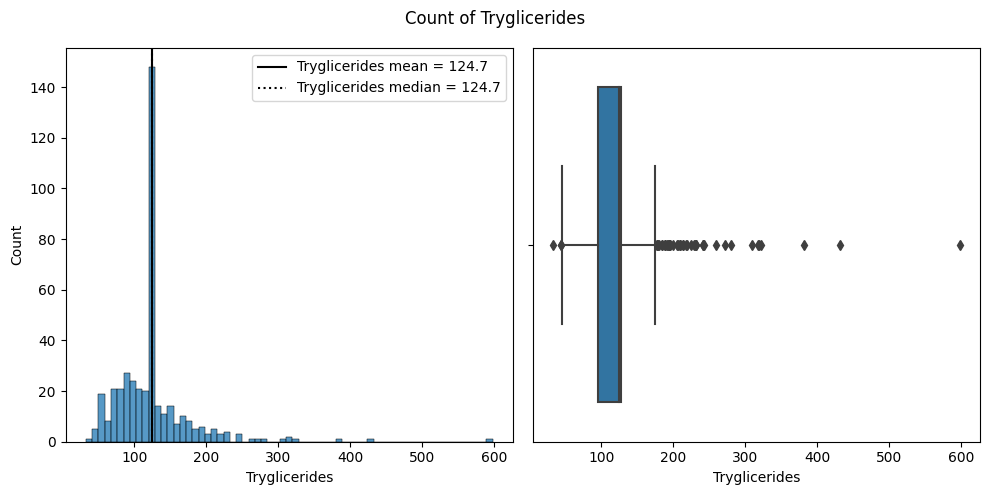

In [239]:
# Tryglicerides
fig, axes=hist_box_plot(df,'Tryglicerides')

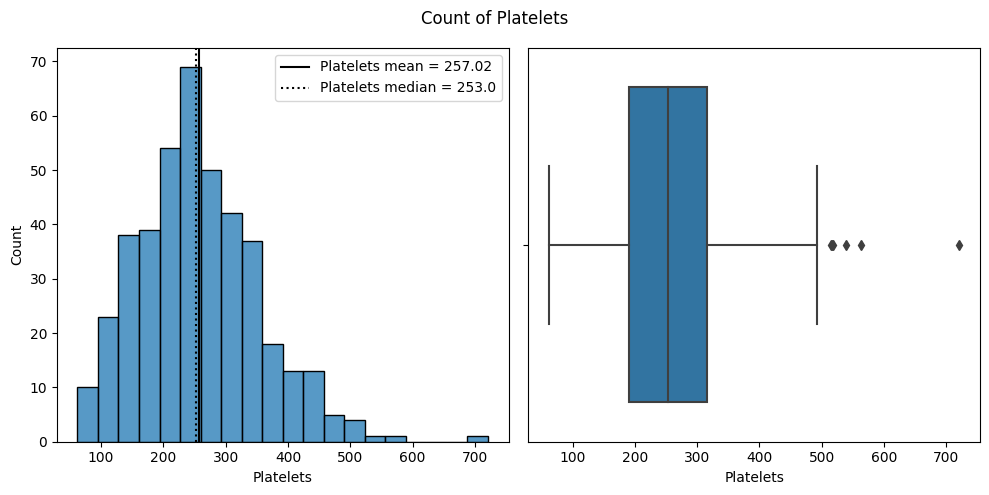

In [240]:
# Platelets
fig, axes=hist_box_plot(df,'Platelets')

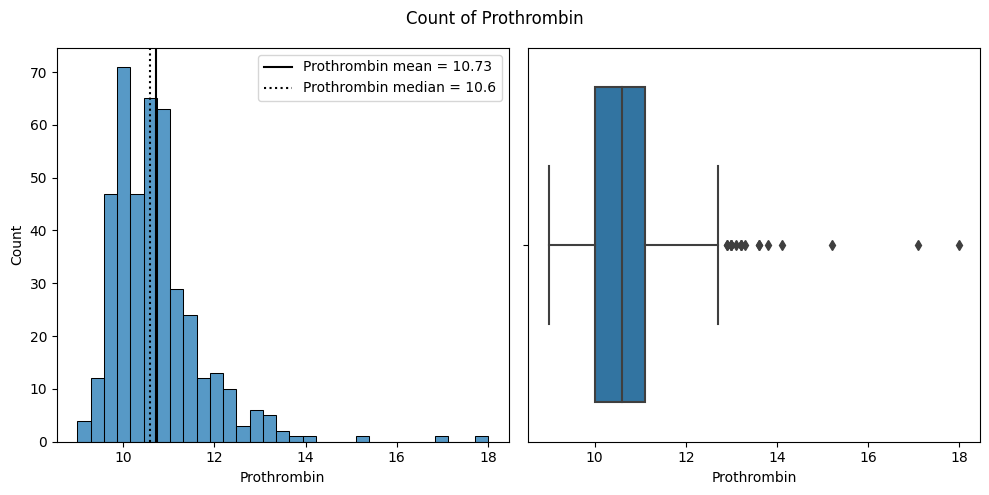

In [241]:
# Prothrombin
fig, axes=hist_box_plot(df,'Prothrombin')